In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import pickle

from scipy.ndimage.measurements import label

import time

from moviepy.editor import VideoFileClip
from functools import reduce

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (9,9)

In [3]:
def show_images(img1, img2, title1='Original Image', title2='New Image', fsize=20):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 7))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=fsize)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(title2, fontsize=fsize)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [4]:
# Load the images
tool_fnames = glob.glob('train_data/tools/**/*.jpg')
nontool_fnames = glob.glob('train_data/non_tools/*.jpg')

tool_image = mpimg.imread(tool_fnames[0])
nontool_image = mpimg.imread(nontool_fnames[0])

print('Number of tool images: {}'.format(len(tool_fnames)))
print('Number of non_tool images: {}'.format(len(nontool_fnames)))
print('Image shape {} and type {}'.format(tool_image.shape, tool_image.dtype))

Number of tool images: 3156
Number of non_tool images: 2560
Image shape (64, 64, 3) and type uint8


In [5]:
# Visualize the data
def visualize_data(fnames, title='tool'):
    num_visualize = 5
    f, axs = plt.subplots(1, num_visualize, figsize=(16,16))
    axs = axs.ravel()
    
    for i in range(num_visualize):
        index = np.random.randint(0, len(fnames))
        img = mpimg.imread(fnames[index])
        axs[i].set_title(title)
        axs[i].axis('off')
        axs[i].imshow(img)

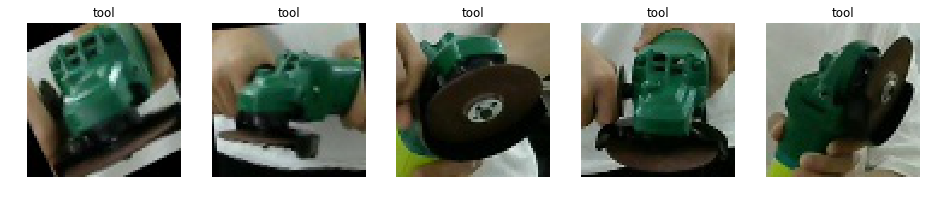

In [6]:
visualize_data(tool_fnames, 'tool')

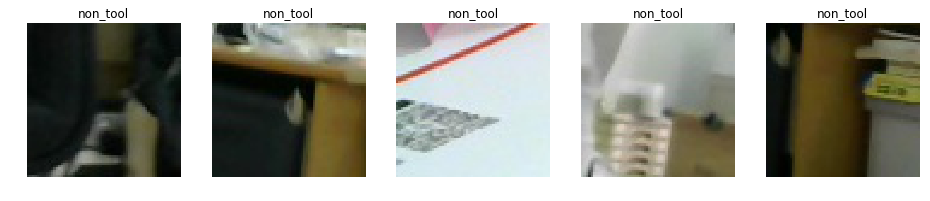

In [7]:
visualize_data(nontool_fnames, 'non_tool')

In [8]:
def convert_color(image, cspace='YCrCb'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        elif cspace == 'Gray':
            return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else: return np.copy(image)

In [9]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

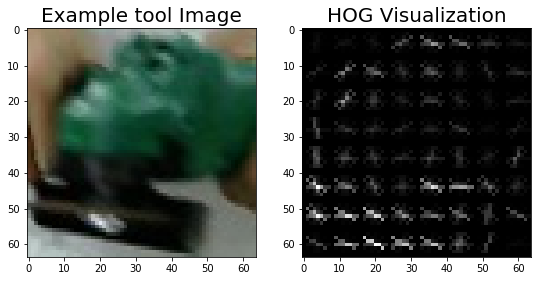

In [10]:
gray = convert_color(tool_image, 'Gray')

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 1, 
                        vis=True, feature_vec=False)


show_images(tool_image, hog_image, title1='Example tool Image', title2='HOG Visualization')

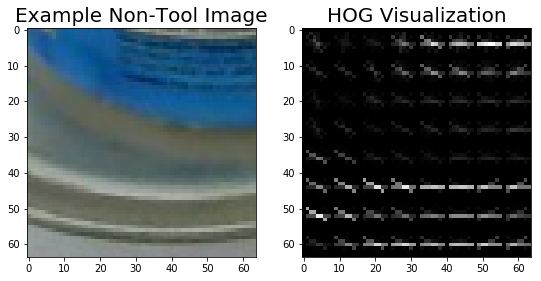

In [11]:
gray = convert_color(nontool_image, 'Gray')

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 1, 
                        vis=True, feature_vec=False)


show_images(nontool_image, hog_image, title1='Example Non-Tool Image', title2='HOG Visualization')

In [12]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(8, 8)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

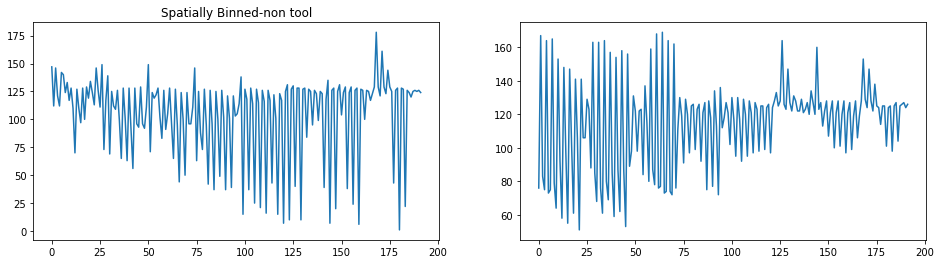

In [13]:
tool_ycrcb = convert_color(tool_image, 'YUV')
nontool_ycrcb = convert_color(nontool_image, 'YUV')

spatial_tool = bin_spatial(tool_ycrcb)
spatial_nontool = bin_spatial(nontool_ycrcb)

f, axs = plt.subplots(1, 2, figsize=(16, 4))
axs = axs.ravel()

axs[0].set_title('Spatially Binned-tool')
axs[0].plot(spatial_tool)
axs[0].set_title('Spatially Binned-non tool')
axs[1].plot(spatial_nontool)

In [14]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=8, visualize=False):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
       
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [15]:
class FeatureParams():
    def __init__(self):
        # HOG parameters
        self.cspace = 'YCrCb'
        self.orient = 9
        self.pix_per_cell = 8
        self.cell_per_block = 1
        self.hog_channel = 'ALL' # can be 0,1,2 or 'ALL'
        # spatial binning parameters
        self.size = (8,8)
        # color histogram parameters
        self.hist_bins = 8

params = FeatureParams()

In [16]:
def extract_features(image, params, spatial_feat=True, hist_feat=True, hog_feat=True):
    # Parameters extraction
    # HOG parameters
    cspace = params.cspace
    orient = params.orient
    pix_per_cell = params.pix_per_cell
    cell_per_block = params.cell_per_block
    hog_channel = params.hog_channel
    # Spatial parameters
    size = params.size
    # Histogram parameters
    hist_bins = params.hist_bins
    
    # apply color conversion if other than 'RGB'
    feature_image = convert_color(image, cspace)
    
    img_features = []
    
    if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_features)
        
    if spatial_feat == True:
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size)
        img_features.append(spatial_features)
    
    if hist_feat == True:
        # Apply color_hist() 
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
        
    return np.concatenate(img_features)
    #return np.concatenate((spatial_features, hist_features, hog_features))

In [17]:
tool_images = list(map(lambda fname: mpimg.imread(fname), tool_fnames))
nontool_images = list(map(lambda fname: mpimg.imread(fname), nontool_fnames))

In [18]:
print('Extract features...')
t = time.time()
tool_features = list(map(lambda img: extract_features(img, params), tool_images))
nontool_features = list(map(lambda img: extract_features(img, params), nontool_images))
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

Extract features...
27.67 Seconds to extract features...


In [19]:
def split_train_test(tool_features, nontool_features):
    # Create an array stack of feature vectors
    X = np.vstack((tool_features, nontool_features)).astype(np.float64)
    # Define the labels vector
    y = np.hstack((np.ones(len(tool_features)), np.zeros(len(nontool_features))))
    
    # Split up data into randomized training and test sets
    rand_state = 2#np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rand_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_train_test(tool_features, nontool_features)

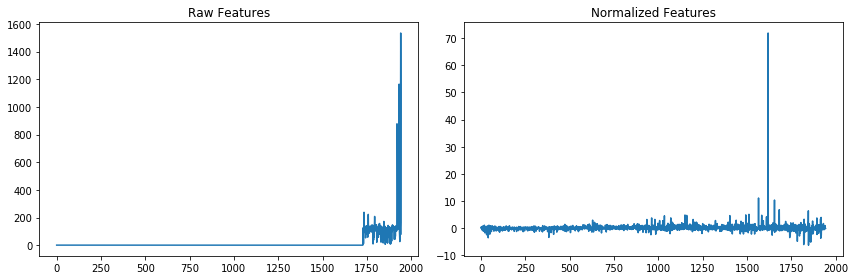

In [20]:
def normalize(X_train, X_test, visualize=False):
    # Fit a per-column scaler
    X_scaler = RobustScaler().fit(X_train)
    # Apply the scaler to X
    scaled_X_train = X_scaler.transform(X_train)
    scaled_X_test = X_scaler.transform(X_test)
    
    if visualize:
        tool_ind = np.random.randint(0, len(tool_features))
        # Plot an example of raw and scaled features
        fig = plt.figure(figsize=(12,4))
        plt.subplot(121)
        plt.plot(X_train[tool_ind])
        plt.title('Raw Features')
        plt.subplot(122)
        plt.plot(scaled_X_train[tool_ind])
        plt.title('Normalized Features')
        fig.tight_layout()
    
    return X_scaler, scaled_X_train, scaled_X_test

scaler, scaled_X_train, scaled_X_test = normalize(X_train, X_test, visualize=True)

In [21]:
X_train[0].shape

(1944,)

In [22]:
def train_model(X_train, X_test, y_train, y_test, load=False):    

    # Check the training time for the SVC
    if load:
        with open('model.pkl', 'rb') as f:
            svc = pickle.load(f)
        print('SVC model loaded')
    else:
        t=time.time()
        svc = LinearSVC()
        svc.fit(X_train, y_train)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train SVC...')
        with open('model','wb') as f:
            pickle.dump(svc,f)
            
    train_accuracy=svc.score(X_train, y_train)
    test_accuracy=svc.score(X_test, y_test)
    print('Train Accuracy: {}'.format(round(train_accuracy, 4)))
    print('Test Accuracy: {}'.format(round(test_accuracy, 4)))

    t = time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    
    return svc

In [23]:
svc = train_model(scaled_X_train, scaled_X_test, y_train, y_test, load=False)

0.49 Seconds to train SVC...
Train Accuracy: 1.0
Test Accuracy: 0.9991
My SVC predicts:  [1. 1. 1. 0. 1. 1. 1. 1. 1. 0.]
For these 10 labels:  [1. 1. 1. 0. 1. 1. 1. 1. 1. 0.]
0.00499 Seconds to predict 10 labels with SVC


### test svc and scaler

In [24]:
pos_image = mpimg.imread('test_image/pos_test.jpg')
neg_image = mpimg.imread('test_image/neg_test.jpg')

positive = extract_features(pos_image, params, spatial_feat=True, hist_feat=True, hog_feat=True)
negative = extract_features(neg_image, params, spatial_feat=True, hist_feat=True, hog_feat=True)

positive = positive.reshape(1,-1)
negative = negative.reshape(1,-1)
#positive.shape
positive = scaler.transform(positive)
negative = scaler.transform(negative)

predict_pos = svc.predict(positive)
predict_neg = svc.predict(negative)

print(predict_pos[0])
print(predict_neg[0])

1.0
0.0


In [94]:
# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=2):
    # make a copy of the image
    draw_img = np.copy(img)
    for bbox in bboxes:
        (x1,y1),(x2,y2) = bbox
        cv2.rectangle(draw_img, (x1, y1), (x2, y2), color, thick)
    # draw each bounding box on your image copy using cv2.rectangle()
    # return the image copy with boxes drawn
    return draw_img

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.85, 0.85)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

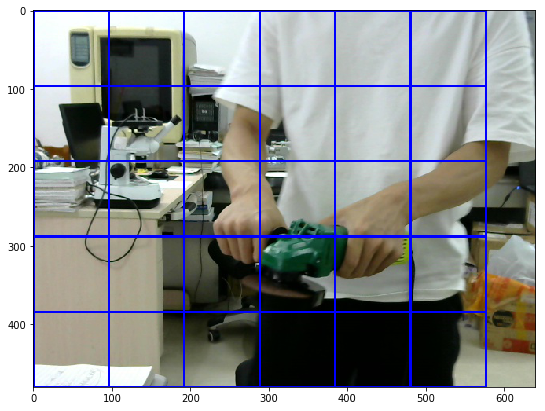

In [95]:
test_image = mpimg.imread('test_image/tool/tool19.jpg')
slide_windows = slide_window(test_image, xy_window=(96,96), xy_overlap=(0, 0))
bboxs_image = draw_boxes(test_image, slide_windows)
plt.imshow(bboxs_image)

In [96]:
# Define a function you will pass an image
# and it will return a list of windows contain cars 
def search_windows(img, clf, scaler, params, xy_window=(64, 64), xy_overlap=(0.8, 0.8)):
    # img = img.astype(np.float32)/255
    windows = slide_window(img, xy_window=xy_window)
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        window_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64), interpolation=cv2.INTER_CUBIC)
        # print(window[0][1],window[1][1],window[0][0],window[1][0])
        # plt.imshow(window_img)
        # cv2.imwrite('strange.jpg', window_img)
        #4) Extract features for that window using single_img_features()
        features = extract_features(window_img, params, spatial_feat=True, hist_feat=True, hog_feat=True)
        features = features.reshape(1, -1)
        #5) Scale extracted features to be fed to classifier
        window_features = scaler.transform(features)
        #6) Predict using your classifier
        pred = clf.predict(window_features)
        #7) If positive (prediction == 1) then save the window
        if pred[0] == 1:
            #print("find tool!")
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

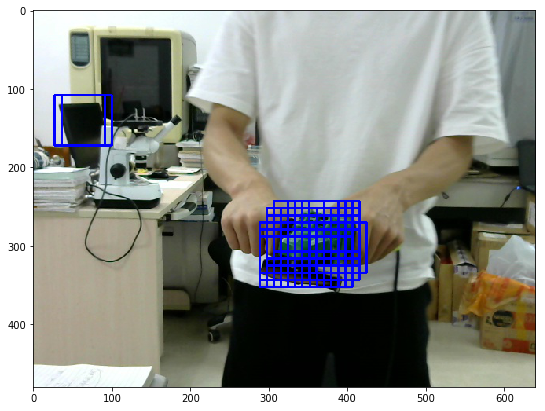

In [106]:
test_image = mpimg.imread('test_image/tool/tool20.jpg')
on_windows = search_windows(test_image, svc, scaler, params)
tool_box_image = draw_boxes(test_image, on_windows)
plt.imshow(tool_box_image)

In [100]:
test_fnames = glob.glob('test_image/tool/*.jpg')
test_images = list(map(lambda fname: mpimg.imread(fname), test_fnames))
tool_boxes_images = list(map(lambda img: draw_boxes(img, search_windows(img, svc, scaler, params)), test_images))

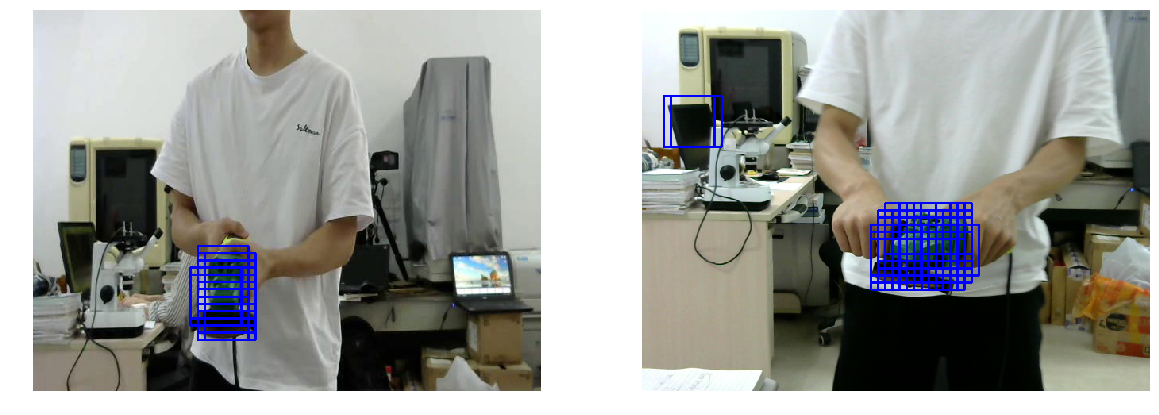

In [104]:
def show_boxes(images, cols = 2, rows = 0):
    rows = int(np.ceil(len(images)/cols))
    f, axs = plt.subplots(rows, cols, figsize=(20, 10))
    axs = axs.ravel()
    for i in range(len(axs)):
        if i < len(images):
            axs[i].axis('off')
            axs[i].imshow(images[i])
        else:
            f.delaxes(axs[i])

show_boxes(tool_boxes_images)

In [107]:
def find_tools(img, clf, scaler, params, y_start_stop=[128, 450], x_start_stop=[100, 540], xy_window=(64, 64), xy_overlap=(0.8, 0.8), window=64, cells_per_step=1, scale=1, return_all=False):
    
    # HOG parameters
    cspace = params.cspace
    orient = params.orient
    pix_per_cell = params.pix_per_cell
    cell_per_block = params.cell_per_block
    hog_channel = params.hog_channel # can be 0,1,2 or 'ALL'
    # spatial binning parameters
    spatial_size = params.size
    # color histogram parameters
    hist_bins = params.hist_bins
    
    draw_img = np.copy(img)
    # img = img.astype(np.float32)/255
    
    ystart, ystop = y_start_stop
    xstart, xstop = x_start_stop
    img_tosearch = img[ystart:ystop, xstart:xstop, :]
    ctrans_tosearch = convert_color(img_tosearch, cspace=cspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    tool_windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins, visualize=False)

            # Scale features and make a prediction
            test_features = scaler.transform(np.hstack((hog_features, spatial_features, hist_features)).reshape(1, -1)) 
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or return_all:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                tool_windows.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))
                
    return tool_windows

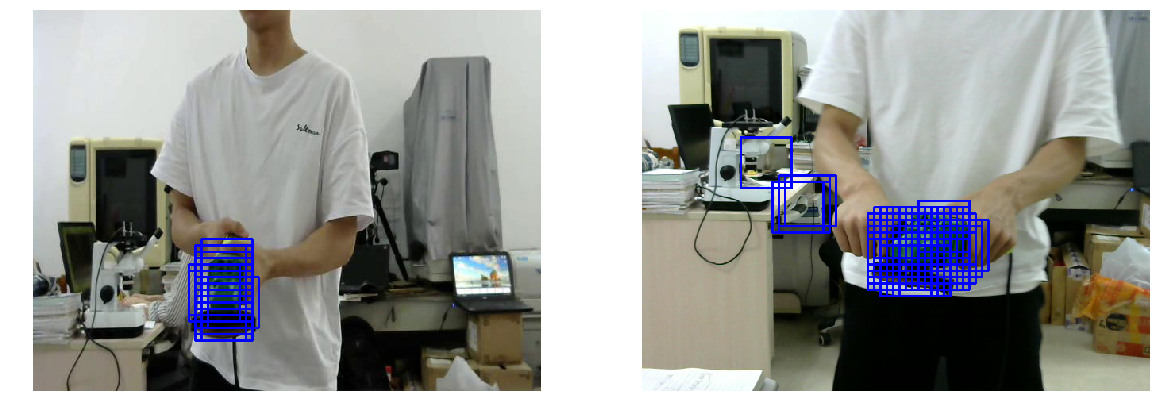

In [108]:
test_fnames = glob.glob('test_image/tool/*.jpg')
test_images = list(map(lambda fname: mpimg.imread(fname), test_fnames))
tool_boxes = list(map(lambda img: draw_boxes(img, find_tools(img, svc, scaler, params)), test_images))
show_boxes(tool_boxes)

In [109]:
def multi_scale_find_tools(img, clf, scaler, params, return_all=False):
    scales = np.array([0.5, 0.7, 0.9])
    y_start_stops = [[128,450],[120,450],[120,450]]
    x_start_stops = [[100,540],[100,540],[100,540]]
    tool_windows = []
    for i in range(len(scales)):
        scale = scales[i]
        for j in range(1):
            y_offset = j*16
            windows = find_tools(img, svc, scaler, params, y_start_stop=[y_start_stops[i][0],y_start_stops[i][1]+y_offset], x_start_stop=x_start_stops[i], scale=scale, return_all=return_all)
            tool_windows.extend(windows)
    return np.array(tool_windows)

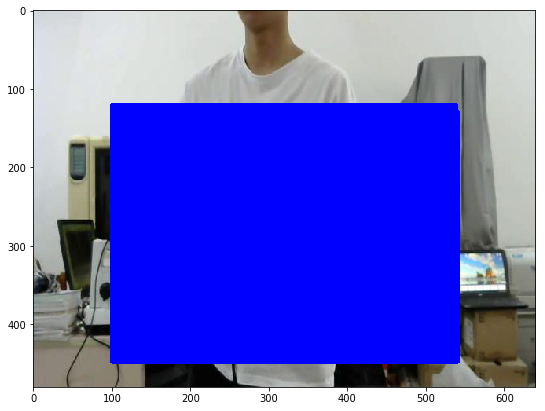

In [110]:
all_windows = multi_scale_find_tools(test_images[0], svc, scaler, params, return_all=True)
window_img = draw_boxes(test_images[0], all_windows, color=(0, 0, 255), thick=3)                    
plt.imshow(window_img)

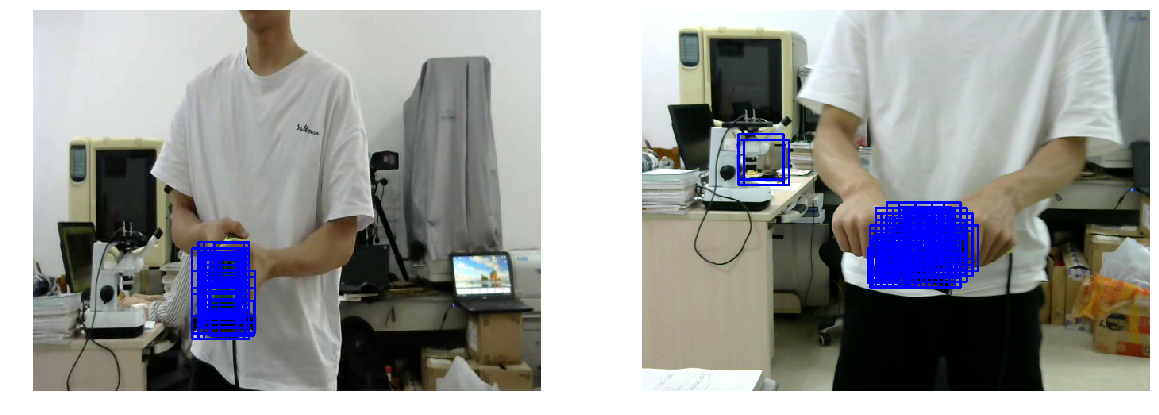

In [111]:
tool_boxes = list(map(lambda img: draw_boxes(img, multi_scale_find_tools(img, svc, scaler, params)), test_images))
show_boxes(tool_boxes)

In [112]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected tools
    for tool_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == tool_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [113]:
def draw_labeled_windows(image, boxes, threshold=2):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,boxes) 
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return heatmap, labels, draw_img

In [114]:
frame_fnames = glob.glob('output_images/*.jpg')

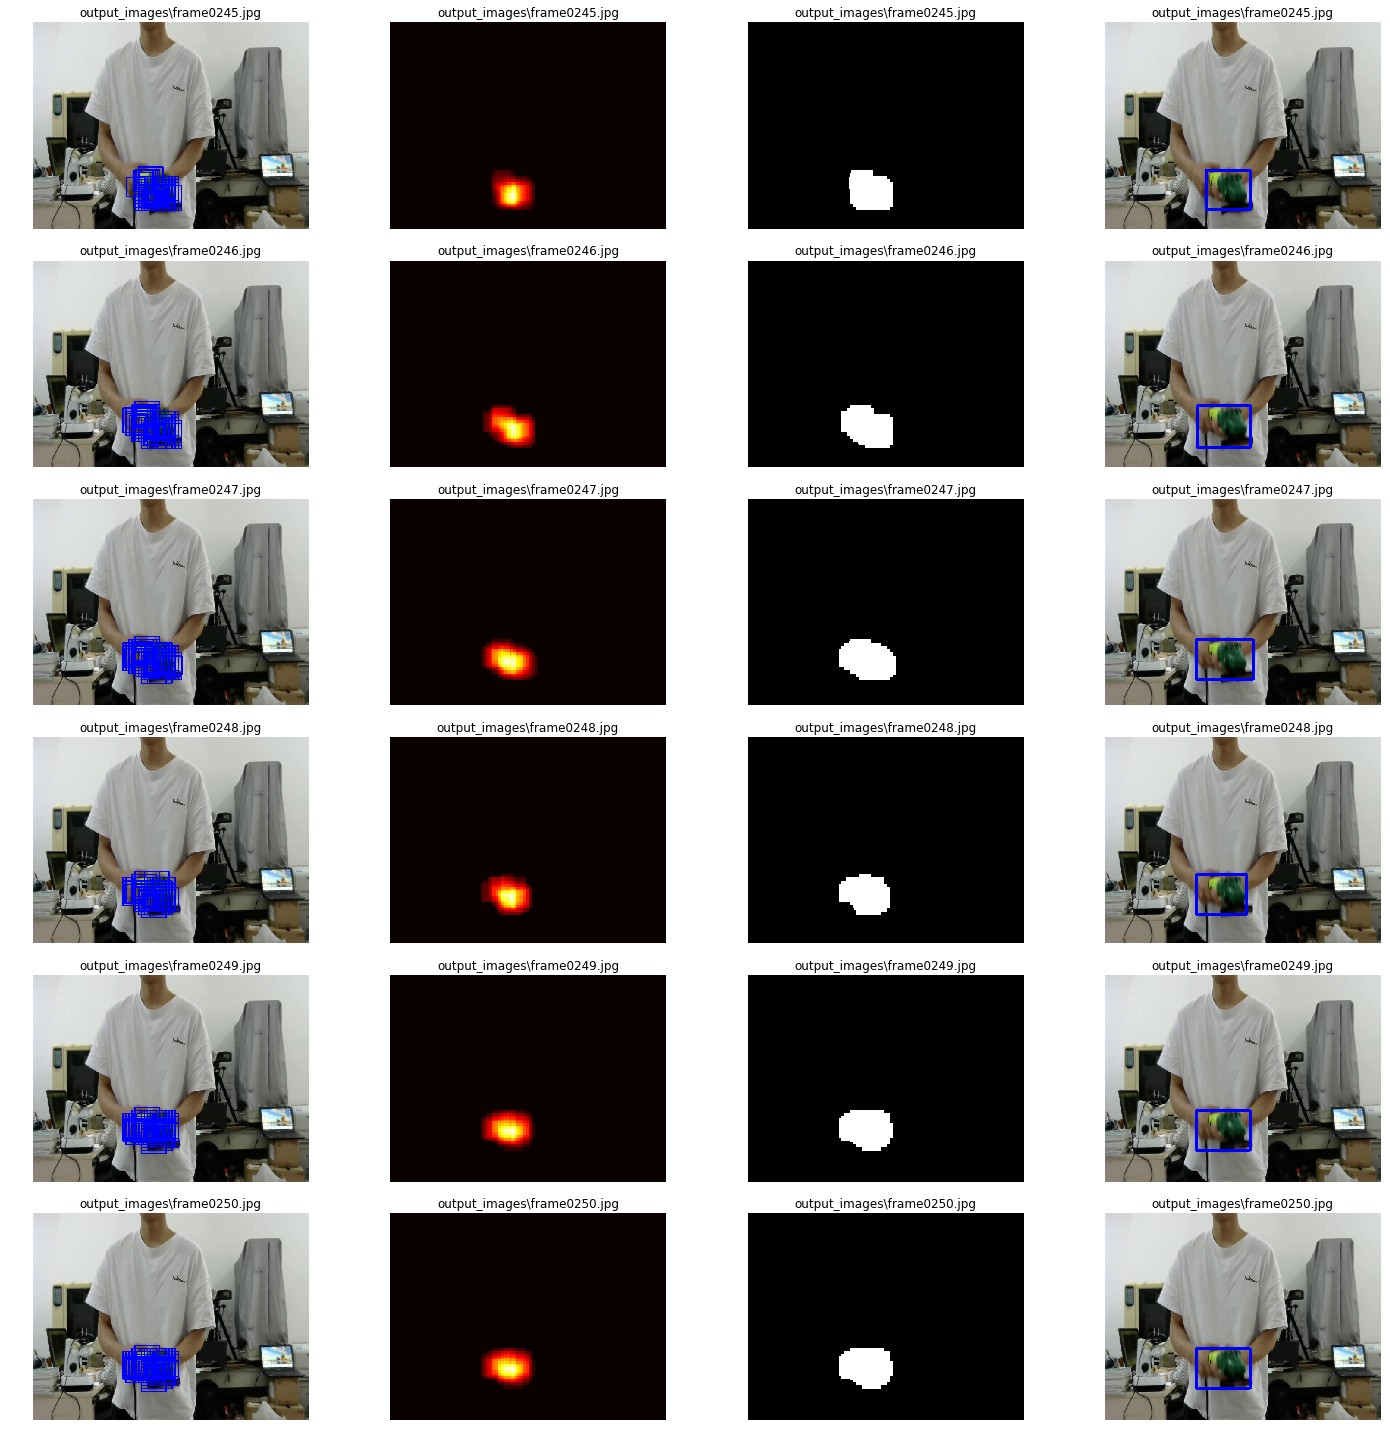

In [115]:
num_frames = 6
f, axs = plt.subplots(num_frames,4, figsize=(20,24))
f.tight_layout()
for i in range(num_frames):
    fname = frame_fnames[-(num_frames-i)]
    img = mpimg.imread(fname)
    tool_windows = multi_scale_find_tools(img, svc, scaler, params)
    tool_boxes = draw_boxes(img, tool_windows)
    heatmap, labels, draw_image = draw_labeled_windows(img, tool_windows)

    axs[i][0].set_title(fname)
    axs[i][0].axis('off')
    axs[i][0].imshow(tool_boxes)
    axs[i][1].set_title(fname)
    axs[i][1].axis('off')
    axs[i][1].imshow(heatmap, cmap='hot')
    axs[i][2].set_title(fname)
    axs[i][2].axis('off')
    axs[i][2].imshow(labels[0], cmap='gray')
    axs[i][3].set_title(fname)
    axs[i][3].axis('off')
    axs[i][3].imshow(draw_image)

In [41]:
from collections import deque
recent_detected = deque(maxlen=20) 

def pipeline(image, svc=svc, scaler=scaler, params=params, combine_detection=True):
    global recent_detected
    tool_windows = multi_scale_find_tools(image, svc, scaler, params)
    if combine_detection:
        recent_detected.append(tool_windows)
        #[item for sublist in list for item in sublist]
        combined_detected = np.array([window for detection in recent_detected for window in detection]).astype(int)
        _,_,draw_image = draw_labeled_windows(image, combined_detected, threshold=32)
    else:
        _,_,draw_image = draw_labeled_windows(image, tool_windows, threshold=1)
    return draw_image

In [ ]:
test_fnames = glob.glob('output_images/*.jpg')
test_images = list(map(lambda fname: mpimg.imread(fname), test_fnames))
test_images = test_images[0:100]
tool_boxes_images = list(map(lambda img: draw_boxes(img, search_windows(img, svc, scaler, params)), test_images))

In [ ]:
pipeline_images = list(map(lambda img: pipeline(img, combine_detection=False), test_images))[0:6]
show_boxes(pipeline_images)

In [43]:
def test_video(src_path, dst_path):
    global recent_detected
    recent_detected.clear()        

    clip1 = VideoFileClip(src_path)

    white_clip = clip1.fl_image(pipeline)

    %time white_clip.write_videofile(dst_path, audio=False)

In [44]:
test_video('test_video.mp4','test_videos_output/test_video.mp4')

[MoviePy] >>>> Building video test_videos_output/test_video.mp4
[MoviePy] Writing video test_videos_output/test_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [22:09<00:00,  5.30s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/test_video.mp4 

Wall time: 22min 9s


### Compare "Single Search", "Sub Sampling Window", "Multi-scale Window" 
比较“滑动窗口”、“二次采样窗口”、“多尺度窗口”

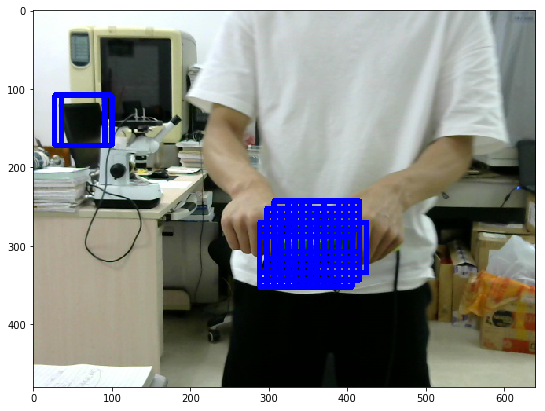

In [87]:
test_fnames = 'test_image/tool/tool20.jpg'
test_images = mpimg.imread(test_fnames)
tool_boxes = draw_boxes(test_images, search_windows(test_images, svc, scaler, params))
plt.imshow(tool_boxes)

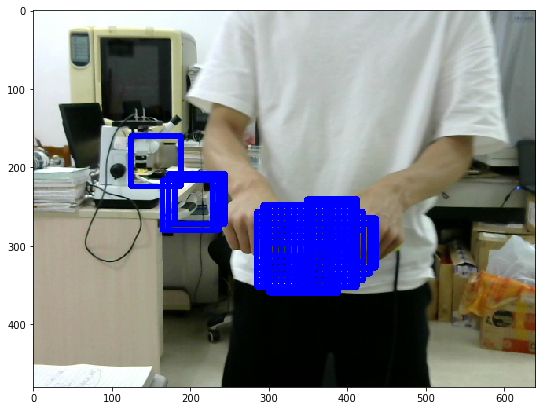

In [88]:
tool_boxes = draw_boxes(test_images, find_tools(test_images, svc, scaler, params))
plt.imshow(tool_boxes)

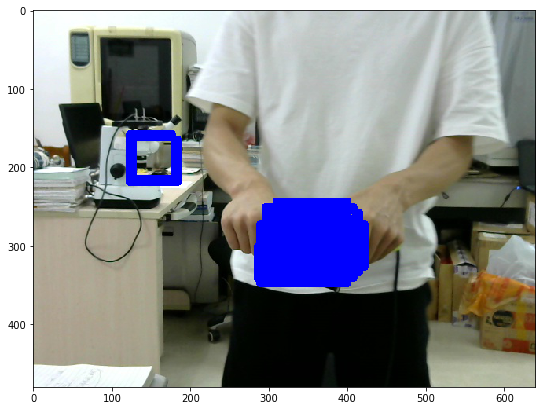

In [89]:
tool_boxes = draw_boxes(test_images, multi_scale_find_tools(test_images, svc, scaler, params))
plt.imshow(tool_boxes)